In [1]:
from pathlib import Path

import networkx
import torch
import torchinfo
from torch import nn
from torch_geometric.datasets.citation_full import CitationFull
from torch_geometric.utils import to_networkx
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.common.utils.sparse import ones_tensor
from torchlake.graph.models import Gat
from tqdm import trange

ImportError: cannot import name 'Gat' from 'torchlake.graph.models' (d:\research\pytorch-implementations\.venv\Lib\site-packages\torchlake\graph\models\__init__.py)

# setting

In [ ]:
data_path = Path("../../data/pubmed")
artifacts_path = Path("../../artifacts/gat")

In [ ]:
device = torch.device("cuda:0")

# data

In [ ]:
dataset = CitationFull(data_path.as_posix(), 'PubMed')

In [ ]:
dataset._data

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717])

In [ ]:
networkx.write_gexf(
    to_networkx(dataset._data, to_undirected=True),
    artifacts_path / "pubmed.gexf",
)

browse graph in gephi(a JAVA program)

# model

In [ ]:
feature_size = dataset.num_node_features
label_size = dataset.num_classes

In [ ]:
model = Gat(feature_size, 128, label_size).to(device)

In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
Gcn                                      --
├─GcnLayer: 1-1                          --
│    └─Linear: 2-1                       64,128
├─GcnLayer: 1-2                          --
│    └─Linear: 2-2                       387
Total params: 64,515
Trainable params: 64,515
Non-trainable params: 0

# train

In [ ]:
epoch = 300

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
A = ones_tensor(dataset.edge_index)

In [ ]:
for e in trange(epoch):
    running_loss = 0.0
    
    optimizer.zero_grad()
    X = dataset.x.to(device)
    A = A.to(device)
    Y = dataset.y.to(device)
    
    output = model(X, A)
    loss = criterion(output, Y)
    running_loss += loss.item()
    
    loss.backward()
    optimizer.step()
    
    print(f"epoch {e+1}: {running_loss/dataset.x.size(0)}")

# evaluation

In [ ]:
with torch.no_grad():
    model.eval()

    confusion_matrix = IncrementalConfusionMatrix(label_size)

    output = model(dataset.x.to(device), A.to(device)).argmax(-1)

    confusion_matrix.update(
        dataset.y.numpy(),
        output.view(-1).detach().cpu().numpy(),
    )

    print(confusion_matrix)

[[3215  192  696]
 [ 379 6554  806]
 [ 272 1467 6136]]


In [ ]:
evaluator = ClassificationEvaluator(label_size, device)

In [ ]:
per_class_accs = evaluator.get_per_class_accuracy(confusion_matrix)

evaluator.show_per_class_accuracy(['0', '1', '2'], per_class_accs)

0         : 0.783572995369242
1         : 0.8468794417883447
2         : 0.7791746031746032


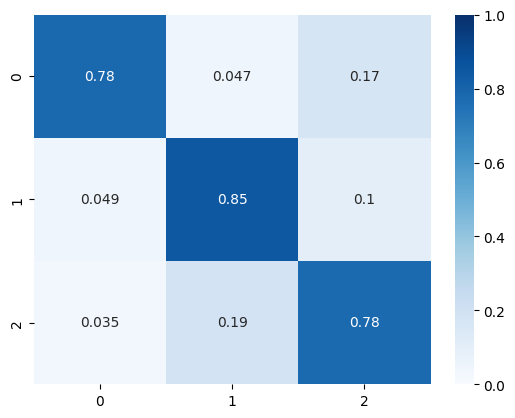

In [ ]:
evaluator.plot_confusion_matrix(confusion_matrix, ['0', '1', '2'], cmap='Blues')

In [ ]:
model_path = artifacts_path.joinpath("gcn.pth")

In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>